In [73]:
import numpy as np
import torch
import nibabel as nib
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from monai.transforms import (
    Compose,
    LoadImaged,
    AddChanneld,
    CropForegroundd,
    Spacingd,
    Orientationd,
    SpatialPadd,
    NormalizeIntensityd,
    RandCropByPosNegLabeld,
    RandRotated,
    RandZoomd,
    CastToTyped,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandAdjustContrastd,
    RandFlipd,
    ToTensord,
)

Define (random) transformations for images.

In [74]:

def brats_transform(image_keys, all_keys):
    
    train_transform = Compose([
        AddChanneld(keys=all_keys),
        CropForegroundd(keys=all_keys, source_key=image_keys[0]),
        Orientationd(keys=all_keys, axcodes="RA"),
        SpatialPadd(keys=all_keys, spatial_size=[240, 240]),
        RandZoomd(
            keys=all_keys,
            min_zoom=0.9,
            max_zoom=1.5,
            mode=("bilinear",) * len(image_keys) + ("nearest",),
            align_corners=(True,) * len(image_keys) + (None,),
            prob=0.3,
        ),
        RandRotated(
            keys=all_keys,
            range_x=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
            range_y=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
            mode=("bilinear",) * len(image_keys) + ("nearest",),
            align_corners=(True,) * len(image_keys) + (None,),
            padding_mode=("border", ) * len(all_keys),
            prob=0.3,
        ),
        RandAdjustContrastd(  # same as Gamma in nnU-Net
            keys=image_keys,
            gamma=(0.7, 1.5),
            prob=0.3,
        ),
        RandFlipd(all_keys, spatial_axis=[0], prob=0.5),  # Only right-left flip
        # NormalizeIntensityd(keys=image_keys, nonzero=True, channel_wise=True),
        CastToTyped(keys=all_keys, dtype=(np.float32,) * len(image_keys) + (np.uint8,)),
        ToTensord(keys=all_keys),
    ])
    return train_transform

Import experiment data

In [75]:
# define path
base_path = '../data/BRaTS2021/BRaTS2021_experiment_nii/test/' 
sample_id = '00002'
slice_id = '77'

# path = 'data\BRaTS2021\BRaTS2021_experiment_nii\test\BraTS2021_00002_flair_76.nii.gz'

print(base_path  + 'BraTS2021_' + sample_id + '_flair_' + slice_id + '.nii.gz')

flair   = nib.load(base_path  + 'BraTS2021_' + sample_id + '_flair_' + slice_id + '.nii.gz').get_fdata()
t1     = nib.load(base_path  + 'BraTS2021_' + sample_id + '_t1_' + slice_id + '.nii.gz').get_fdata()
t1ce   = nib.load(base_path  + 'BraTS2021_' + sample_id + '_t1ce_' + slice_id + '.nii.gz').get_fdata()
t2     = nib.load(base_path  + 'BraTS2021_' + sample_id + '_t2_' + slice_id + '.nii.gz').get_fdata()
seg    = nib.load(base_path  + 'BraTS2021_' + sample_id + '_seg_' + slice_id + '.nii.gz').get_fdata()

# print number of slices
imgshape = flair.shape
print(f"shape: {imgshape}")

../data/BRaTS2021/BRaTS2021_experiment_nii/test/BraTS2021_00002_flair_77.nii.gz
shape: (240, 240)


Apply transformation

See here for more information:

https://github.com/Project-MONAI/tutorials/blob/main/modules/3d_image_transforms.ipynb

https://docs.monai.io/en/stable/transforms.html



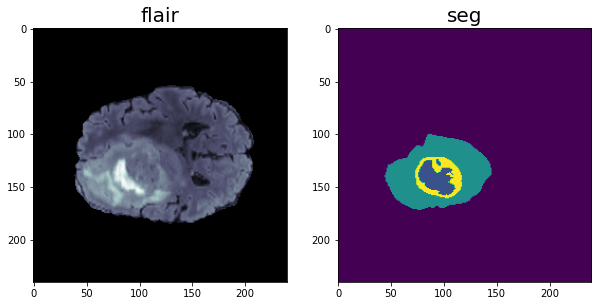

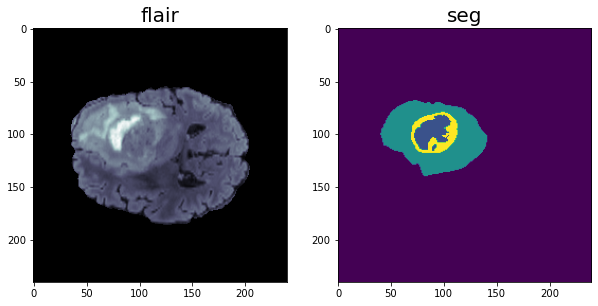

In [76]:
transform = brats_transform(image_keys=["flair", "t1", "t1ce", "t2"], all_keys=["flair", "t1", "t1ce", "t2", "seg"])

# apply transform
data_dict = transform({"flair": flair, "t1": t1, "t1ce": t1ce, "t2": t2, "seg": seg})

# image, label = data_dict[0]["flair"], data_dict[0]["seg"]

image, label = data_dict["flair"], data_dict["seg"]

# squeeze the image and label
image = image
label = label

# original
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(flair, cmap="bone")
plt.title("flair", fontsize=20)
plt.subplot(1, 2, 2)
plt.imshow(seg)
plt.title("seg", fontsize=20)
plt.show()

# augmented
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("flair", fontsize=20)
plt.imshow(image[0], cmap="bone")
plt.subplot(1, 2, 2)
plt.title("seg", fontsize=20)
plt.imshow(label[0])
plt.show()